## DDQN in Hockey Enviroment - Training

Train a DDQN on various Hockey env. modes

Base DQN implementation adapted from HW7

In [10]:
from importlib import reload

import numpy as np
import gymnasium as gym
from gymnasium import spaces
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import DDQN.DDQN as ddqn
from DDQN.DDQN import DDQNAgent
import hockey.hockey_env as h_env

In [11]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

### Normal Gameplay

#### Weak Opponent

In [20]:
reload(h_env)
#env = DiscreteActionWrapper(h_env.HockeyEnv(mode=h_env.Mode.NORMAL), bins=8)  # TODO: change bin count?
#env = DiscretizedHockey(bins=5, mode=h_env.Mode.NORMAL)
env = h_env.HockeyEnv(mode=h_env.Mode.NORMAL)

env.reset()

(array([-3.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  3.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.01834631,  0.53389502,  0.        ,
         0.        ,  0.        ,  0.        ]),
 {'winner': 0,
  'reward_closeness_to_puck': 0.0,
  'reward_touch_puck': 0.0,
  'reward_puck_direction': 0.0})

In [21]:
DISCOUNT = 0.90
EPS = 0.3
UPDATE_TARGET_FREQ = 30
TAU = 1e-3

DISCRETE_BINS = 5

agent1 = DDQNAgent(
    env.observation_space,
    env.discrete_action_space,
    discount=DISCOUNT,
    epsilon=EPS,
    update_target_freq=UPDATE_TARGET_FREQ,
    tau=TAU
)

agent2 = h_env.BasicOpponent(weak=True)

In [22]:
MAX_EPISODES=500
MAX_STEPS=1000

PRINT_FREQ=25

In [23]:
stats = []
losses = []

for i in tqdm(range(MAX_EPISODES)):
    total_reward = 0
    ob_a1, _info = env.reset()
    ob_a2 = env.obs_agent_two()

    for t in range(MAX_STEPS):
        done = False
        trunc = False

        a1_discr = agent1.act(ob_a1)
        a1 = env.discrete_to_continous_action(a1_discr)
        a2 = agent2.act(ob_a2)
        
        ob_a1_new, reward, done, trunc, _info = env.step(np.hstack([a1, a2]))
        total_reward += reward

        agent1.store_transition((ob_a1, a1_discr, reward, ob_a1_new, done))

        ob_a1 = ob_a1_new
        ob_a2 = env.obs_agent_two()

        if done or trunc:
            break

    loss = agent1.train(32)

    losses.extend(loss)
    stats.append([i, total_reward, t+1])
    
    if (i-1) % PRINT_FREQ == 0:
        print("Ep. {}: Done after {} steps. Reward: {}".format(i, t+1, total_reward))

  0%|          | 0/500 [00:00<?, ?it/s]

Ep. 1: Done after 57 steps. Reward: -11.879795581107977
Ep. 26: Done after 251 steps. Reward: -41.89396856898424
Ep. 51: Done after 54 steps. Reward: -10.923358707489704
Ep. 76: Done after 232 steps. Reward: -32.03123384077692
Ep. 101: Done after 251 steps. Reward: -16.080199630525943
Ep. 126: Done after 89 steps. Reward: -13.164878200451728
Ep. 151: Done after 87 steps. Reward: 9.496765256862583
Ep. 176: Done after 68 steps. Reward: -12.37113960699359
Ep. 201: Done after 48 steps. Reward: -10.701894900748622
Ep. 226: Done after 251 steps. Reward: -15.012144105864731
Ep. 251: Done after 51 steps. Reward: -11.054899686786598
Ep. 276: Done after 29 steps. Reward: 9.635482731235129
Ep. 301: Done after 162 steps. Reward: 7.425871891244972
Ep. 326: Done after 251 steps. Reward: -21.738442761914445
Ep. 351: Done after 219 steps. Reward: -14.026747978269082
Ep. 376: Done after 251 steps. Reward: -15.974326324867823
Ep. 401: Done after 251 steps. Reward: -8.033080435684665
Ep. 426: Done after 

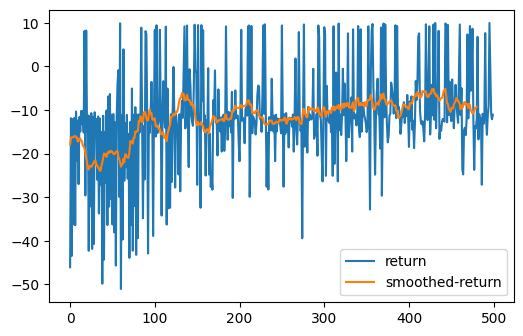

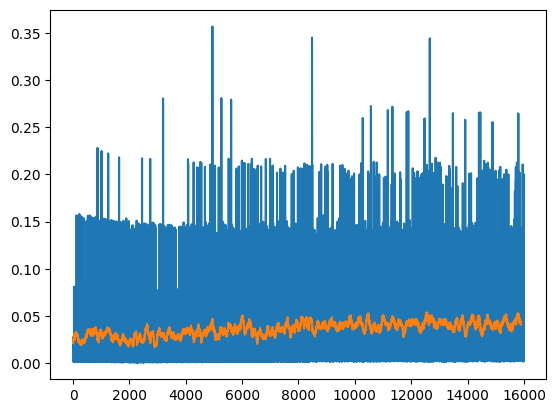

In [24]:
stats_np = np.asarray(stats)
losses_np = np.asarray(losses)
fig=plt.figure(figsize=(6,3.8))
plt.plot(stats_np[:,1], label="return")
plt.plot(running_mean(stats_np[:,1],20), label="smoothed-return")
plt.legend()
plt.show()

plt.figure()
plt.plot(losses_np)
plt.plot(running_mean(losses_np, 100))
plt.show()

## Agent Model Saving

In [25]:
STATE_PATH = "./DDQN/models/hockey_discrete_5bins/"

reload(ddqn)

agent1.save_state(STATE_PATH)

## Visualization

In [18]:
STEPS = 100000

obs_buffer = []
reward_buffer = []
obs, _ = env.reset()
obs_agent2 = env.obs_agent_two()

for i in range(STEPS):
    env.render()
    a1_discr = agent1.act(obs)
    a1 = env.discrete_to_continous_action(a1_discr)
    a2 = agent2.act(obs_agent2)

    obs, r, done, trunc, _ = env.step(np.hstack([a1, a2]))
    obs_buffer.append(obs)
    reward_buffer.append(r)

    obs_agent2 = env.obs_agent_two()

    if done or trunc:
        print(f"Episode done in {i} steps")
        break


Episode done in 42 steps


In [19]:
env.close()